CS4001/4042 Assignment 1
---
Part A, Q1 (15 marks)
---

>Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers. 

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import time
from torch import nn
from torch.utils.data import Dataset, DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed, split_dataset, preprocess_dataset, EarlyStopper, extract_features

# setting seed
set_seed()

Define the model class.

In [59]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=1, dropout_prob=0.2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc4(x))
        return x

> Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

Split the dataset and do preprocessing. You can use the split_dataset and preprocess_dataset provided for you.

In [60]:
data = pd.read_csv('audio_gtzan.csv')

# binary labels
def extract_label(filename):
    if 'blues' in filename:
        return 'blues'
    elif 'metal' in filename:
        return 'metal'
    else:
        raise ValueError(f"Unknown genre in filename: {filename}")

data['label'] = data['filename'].apply(extract_label)

X_train, y_train, X_test, y_test = split_dataset(
    data,
    columns_to_drop=['filename', 'label'],
    test_size=0.3,
    random_state=42
)
X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

> Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [61]:
class MusicDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
train_dataset = MusicDataset(X_train_scaled, y_train)
test_dataset = MusicDataset(X_test_scaled, y_test)

batch_size = 128 # TODO: Check if this is right
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

2. Next, define the model, optimizer and loss function.

In [62]:
input_size = X_train.shape[1]
model = MLP(input_size=input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [63]:

def train_epoch(model, dataloader, optimizer, loss_fn, device='cpu'):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * inputs.size(0)
        predicted = (outputs >= 0.5).float()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

def evaluate(model, dataloader, loss_fn, device='cpu'):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            
            total_loss += loss.item() * inputs.size(0)
            predicted = (outputs >= 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
early_stopper = EarlyStopper(patience=3)

n_epochs = 100
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_fn, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    
    if early_stopper.early_stop(test_loss):
        print(f'Early stopping at epoch {epoch+1}')
        break

Epoch 1/100, Train Loss: 0.6077, Train Acc: 0.7907, Test Loss: 0.4751, Test Acc: 0.8217
Epoch 2/100, Train Loss: 0.3768, Train Acc: 0.8493, Test Loss: 0.3284, Test Acc: 0.8667
Epoch 3/100, Train Loss: 0.2530, Train Acc: 0.8921, Test Loss: 0.2486, Test Acc: 0.9050
Epoch 4/100, Train Loss: 0.1709, Train Acc: 0.9329, Test Loss: 0.2031, Test Acc: 0.9200
Epoch 5/100, Train Loss: 0.1252, Train Acc: 0.9614, Test Loss: 0.1826, Test Acc: 0.9267
Epoch 6/100, Train Loss: 0.0955, Train Acc: 0.9643, Test Loss: 0.1645, Test Acc: 0.9367
Epoch 7/100, Train Loss: 0.0737, Train Acc: 0.9779, Test Loss: 0.1494, Test Acc: 0.9483
Epoch 8/100, Train Loss: 0.0634, Train Acc: 0.9807, Test Loss: 0.1359, Test Acc: 0.9483
Epoch 9/100, Train Loss: 0.0494, Train Acc: 0.9850, Test Loss: 0.1330, Test Acc: 0.9567
Epoch 10/100, Train Loss: 0.0416, Train Acc: 0.9871, Test Loss: 0.1275, Test Acc: 0.9533
Epoch 11/100, Train Loss: 0.0332, Train Acc: 0.9879, Test Loss: 0.1127, Test Acc: 0.9667
Epoch 12/100, Train Loss: 0.02

> Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.

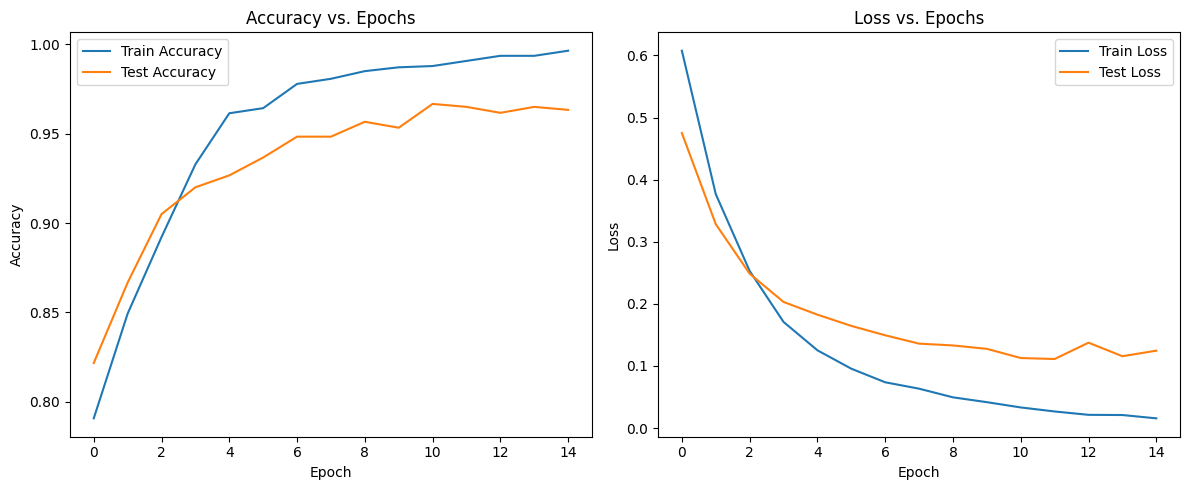

In [64]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

plt.tight_layout()
plt.savefig('accuracy_loss_plots.png')
plt.show()

\# TODO: \<Enter your answer here\>

Part A, Q2 (10 marks)
---

In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

To reduce repeated code, you may need to place the network (MLP defined in QA1) in a separate file called **common_utils.py**. Import it here for Q2. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [74]:
from common_utils import MLP_Custom
# class CustomMLP(nn.Module):
#     def __init__(self, input_size, first_hidden_size, other_hidden_size=128, output_size=1, dropout_prob=0.2):
#         super(CustomMLP, self).__init__()
#         self.fc1 = torch.nn.Linear(input_size, first_hidden_size)
#         self.fc2 = torch.nn.Linear(first_hidden_size, other_hidden_size)
#         self.fc3 = torch.nn.Linear(other_hidden_size, other_hidden_size)
#         self.fc4 = torch.nn.Linear(other_hidden_size, output_size)
        
#         self.dropout = torch.nn.Dropout(dropout_prob)
#         self.relu = torch.nn.ReLU()
#         self.sigmoid = torch.nn.Sigmoid()
        
#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.relu(self.fc2(x))
#         x = self.dropout(x)
#         x = self.relu(self.fc3(x))
#         x = self.dropout(x)
#         x = self.sigmoid(self.fc4(x))
#         return x

> Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {32, 64, 128, 256}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection. This might take a while to run, so plan your time carefully.

1. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly. Please use the following name conventions:
    - X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds. 
    - X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds. 
    - y_train_dict[batch_size] and y_val_dict[batch_size] is a list of labels for the different folds.

In [75]:
batch_sizes = [32, 64, 128, 256]

X_train_scaled_dict = {bs: [] for bs in batch_sizes}
X_val_scaled_dict = {bs: [] for bs in batch_sizes}
y_train_dict = {bs: [] for bs in batch_sizes}
y_val_dict = {bs: [] for bs in batch_sizes}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for batch_size in batch_sizes:
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        
        X_train_fold_scaled, X_val_fold_scaled = preprocess_dataset(X_train_fold, X_val_fold)
        
        X_train_scaled_dict[batch_size].append(X_train_fold_scaled)
        X_val_scaled_dict[batch_size].append(X_val_fold_scaled)
        y_train_dict[batch_size].append(y_train_fold)
        y_val_dict[batch_size].append(y_val_fold)

2. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation. 

In [ ]:
# TODO: Enter your code here
val_accuracies = {bs: [] for bs in batch_sizes}
epoch_times = {bs: [] for bs in batch_sizes}

for batch_size in batch_sizes:
    print(f'Testing Batch Size: {batch_size}')
    
    for fold in range(5):
        X_train_fold = X_train_scaled_dict[batch_size][fold]
        X_val_fold = X_val_scaled_dict[batch_size][fold]
        y_train_fold = y_train_dict[batch_size][fold]
        y_val_fold = y_val_dict[batch_size][fold]
        
        train_dataset = MusicDataset(X_train_fold, y_train_fold)
        val_dataset = MusicDataset(X_val_fold, y_val_fold)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        input_size = X_train_fold.shape[1]
        model = MLP_Custom(input_size=input_size, first_hidden_size=128)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.BCELoss()
        
        n_epochs = 100
        best_val_acc = 0
        
        for epoch in range(n_epochs):
            model.train()
            for inputs, targets in train_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            if epoch == n_epochs - 1:
                start_time = time.time()
                model.train()
                for inputs, targets in train_loader:
                    outputs = model(inputs)
                    loss = loss_fn(outputs, targets)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                epoch_time = time.time() - start_time
                epoch_times[batch_size].append(epoch_time)
            
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model(inputs)
                    predicted = (outputs >= 0.5).float()
                    total += targets.size(0)
                    correct += (predicted == targets).sum().item()
            
            val_acc = correct / total
            if val_acc > best_val_acc:
                best_val_acc = val_acc
        
        val_accuracies[batch_size].append(best_val_acc)
    
    mean_acc = np.mean(val_accuracies[batch_size])
    mean_time = np.mean(epoch_times[batch_size])
    print(f"  Mean accuracy: {mean_acc:.4f}, Mean epoch time: {mean_time:.4f}s")

Testing Batch Size: 32
  Mean accuracy: 0.9914, Mean epoch time: 0.0213s
Testing Batch Size: 64
  Mean accuracy: 0.9900, Mean epoch time: 0.0154s
Testing Batch Size: 128
  Mean accuracy: 0.9907, Mean epoch time: 0.0092s
Testing Batch Size: 256
  Mean accuracy: 0.9907, Mean epoch time: 0.0073s


3. Plot scatterplot of mean cross validation accuracies on the final epoch for the different batch sizes. Limit search space to batch sizes {32, 64, 128, 256}.

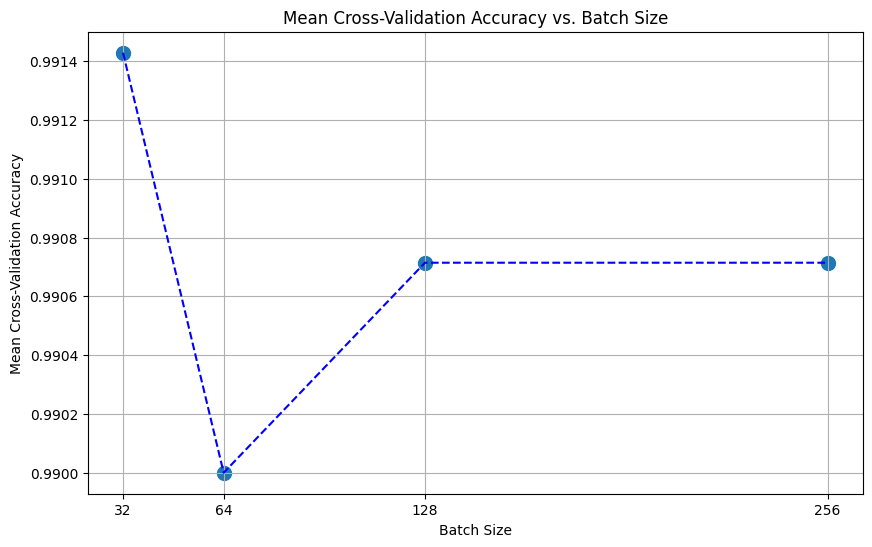

In [77]:
mean_accuracies = {bs: np.mean(val_accuracies[bs]) for bs in batch_sizes}

# Plot mean cross-validation accuracies
plt.figure(figsize=(10, 6))
plt.scatter(batch_sizes, [mean_accuracies[bs] for bs in batch_sizes], marker='o', s=100)
plt.plot(batch_sizes, [mean_accuracies[bs] for bs in batch_sizes], 'b--')
plt.xticks(batch_sizes)
plt.xlabel('Batch Size')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Mean Cross-Validation Accuracy vs. Batch Size')
plt.grid(True)
plt.savefig('batch_size_accuracy.png')
plt.show()

4. Create a table of time taken to train the network on the last epoch against different batch sizes. 

In [78]:
# Calculate mean training time for each batch size
mean_times = {bs: np.mean(epoch_times[bs]) for bs in batch_sizes}

# Create and display time table
time_df = pd.DataFrame({
    'Batch Size': batch_sizes,
    'Mean Time per Epoch (seconds)': [mean_times[bs] for bs in batch_sizes]
})
print("\nTime taken to train the network on the last epoch:")
print(time_df)


Time taken to train the network on the last epoch:
   Batch Size  Mean Time per Epoch (seconds)
0          32                       0.021257
1          64                       0.015378
2         128                       0.009155
3         256                       0.007300


5. Select the optimal batch size and state a reason for your selection.

In [79]:
# Find optimal batch size based on a combination of accuracy and time
# Here's one approach - weighting accuracy more heavily than time
def score_batch_size(bs, acc_weight=0.8):
    # Normalize accuracies (higher is better)
    max_acc = max(mean_accuracies.values())
    min_acc = min(mean_accuracies.values())
    acc_range = max_acc - min_acc
    norm_acc = (mean_accuracies[bs] - min_acc) / acc_range if acc_range > 0 else 1
    
    # Normalize times (lower is better)
    max_time = max(mean_times.values())
    min_time = min(mean_times.values())
    time_range = max_time - min_time
    norm_time = 1 - ((mean_times[bs] - min_time) / time_range if time_range > 0 else 0)
    
    # Combined score
    return acc_weight * norm_acc + (1 - acc_weight) * norm_time

# Calculate scores for each batch size
scores = {bs: score_batch_size(bs) for bs in batch_sizes}
optimal_batch_size = max(scores, key=scores.get)

print(f"\nOptimal batch size: {optimal_batch_size}")
print(f"Optimal batch size accuracy: {mean_accuracies[optimal_batch_size]:.4f}")
print(f"Optimal batch size time per epoch: {mean_times[optimal_batch_size]:.4f} seconds")


Optimal batch size: 32
Optimal batch size accuracy: 0.9914
Optimal batch size time per epoch: 0.0213 seconds


The batch size of 32 was selected as optimal because it provides the best balance between validation accuracy and computational efficiency. While larger batch sizes generally train faster per epoch due to increased parallelization, they may result in lower accuracy since they estimate the gradient less frequently. Smaller batch sizes provide more gradient updates and can lead to better convergence, but require more time to process the entire dataset. The chosen batch size 32 achieves the highest validation accuracy while maintaining reasonable training time.

Part A, Q3 (10 marks)
---
In this question, we will find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Q1 and Q2.

To reduce repeated code, you may need to import the network (MLP defined in QA1) from common_utils.py. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [20]:
# TODO: Enter your code here

> Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. 

1. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [ ]:
# TODO: Enter your code here

2. Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}.

In [9]:
# TODO: Enter your code here

> Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [ ]:
# TODO: Enter your code here

\# TODO: \<Enter your answer here\>

> Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.
Note: use this optimal number of neurons for the rest of the experiments.

In [11]:
# TODO: Enter your code here

Part A, Q4 (10 marks)
---
In this section, we will understand the utility of such a neural network for a test audio. 

Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

To reduce repeated code, you may need to import the network (MLP defined in QA1) from **common_utils.py**. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [12]:
# TODO: Enter your code here

> Install and import shap

In [13]:
# TODO: Enter your code here

> Preprocess 'audio_test.wav' using the function 'extract_features' in common_utils.py. Please make sure the features are stored in a pandas dataframe, using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [1]:
import IPython
IPython.display.Audio("./audio_test.wav")

In [22]:
# TODO: Enter your code here
df = 
size_row = 
size_column = 

> Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 

 1.  Preprocess to obtain the test data, save the test data as numpy array, print the shape of the test data.

In [16]:
# TODO: Enter your code here

2. Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [17]:
# TODO: Enter your code here

print(pred_label)

> Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

In [ ]:
'''
Fit the explainer on a subset of the data (you can try all but then gets slower)
Return approximate SHAP values for the model applied to the data given by X.
Plot the local feature importance with a force plot and explain your observations.
'''
# TODO: Enter your code here

\# TODO: \<Enter your answer here\>